### 读取nii文件

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# 读取 nii 文件
nii_file = 'Data/study_001.nii'  # 请更改为实际文件路径
img = nib.load(nii_file)
data = img.get_fdata()

# 打印数据维度
print('Data shape:', data.shape)


Data shape: (512, 512, 41)


### 可视化原始数据

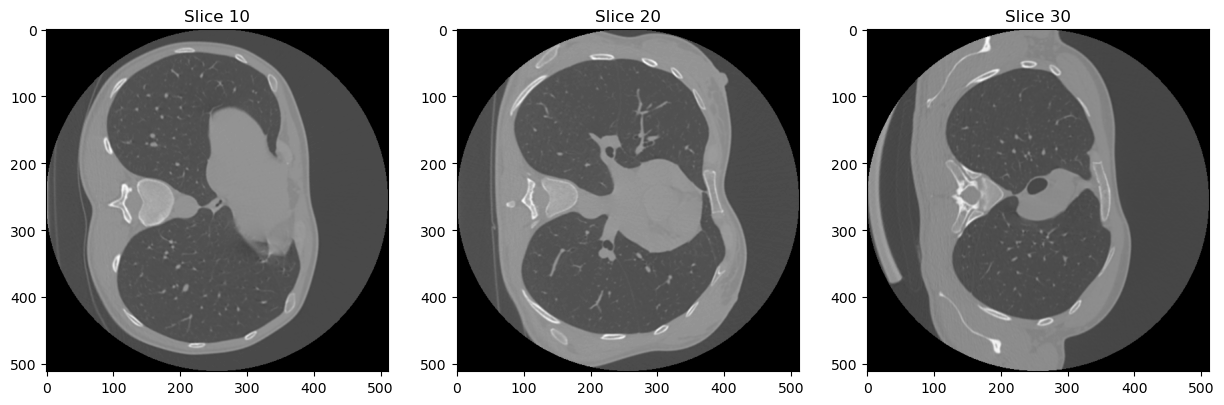

In [3]:
# 可视化原始数据的几个切片
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(data[:, :, 10], cmap='gray')
ax[0].set_title('Slice 10')
ax[1].imshow(data[:, :, 20], cmap='gray')
ax[1].set_title('Slice 20')
ax[2].imshow(data[:, :, 30], cmap='gray')
ax[2].set_title('Slice 30')
plt.show()


### K-Means聚类分割

c:\Users\ghost\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ghost\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ghost\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ghost\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

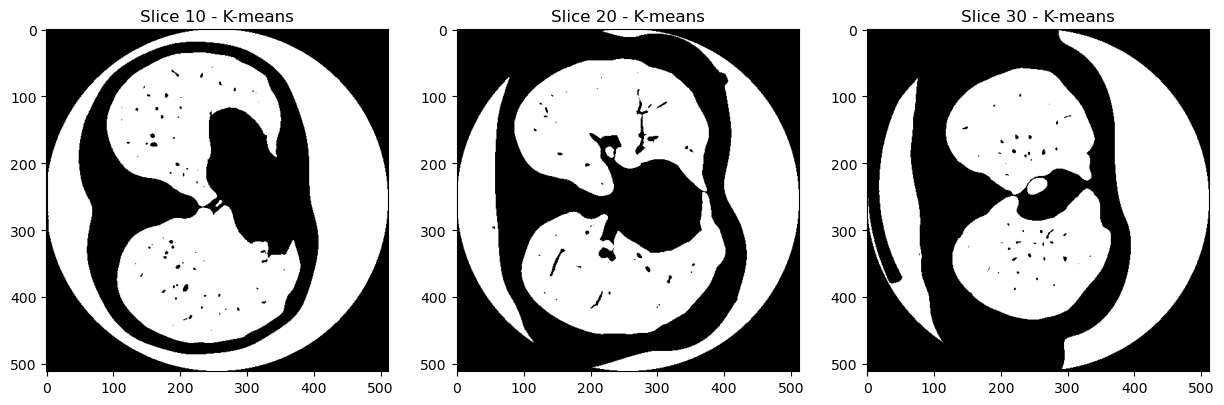

In [4]:
from sklearn.cluster import KMeans

# 对每个切片进行K-means聚类分割
kmeans_data = np.zeros_like(data, dtype=bool)
for i in range(data.shape[2]):
    slice_2d = data[:, :, i]
    slice_1d = slice_2d.reshape(-1, 1)  # 将二维数组重塑为一维数组
    
    # 使用KMeans进行聚类，聚成2个簇
    kmeans = KMeans(n_clusters=3, random_state=0).fit(slice_1d)
    labels = kmeans.labels_.reshape(data.shape[0], data.shape[1])  # 将标签重塑为二维数组
    
    # 确定哪个簇对应于肺部区域
    cluster_0_mean = slice_1d[labels.ravel() == 0].mean()
    cluster_1_mean = slice_1d[labels.ravel() == 1].mean()
    
    if cluster_0_mean < cluster_1_mean:
        kmeans_data[:, :, i] = (labels == 0)
    else:
        kmeans_data[:, :, i] = (labels == 1)

# 可视化K-means聚类结果
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(kmeans_data[:, :, 10], cmap='gray')
ax[0].set_title('Slice 10 - K-means')
ax[1].imshow(kmeans_data[:, :, 20], cmap='gray')
ax[1].set_title('Slice 20 - K-means')
ax[2].imshow(kmeans_data[:, :, 30], cmap='gray')
ax[2].set_title('Slice 30 - K-means')
plt.show()


### 分离浅棕色区域中的深色区域

In [6]:
# 对每个切片进一步分离深色部分
inner_lung_mask = np.zeros_like(data, dtype=bool)
for i in range(data.shape[2]):
    slice = data[:, :, i]
    masked_slice = slice * outer_lung_mask[:, :, i]
    thresh = threshold_otsu(masked_slice)
    inner_lung_mask[:, :, i] = masked_slice < thresh

# 可视化分离出的深色区域（肺部区域）
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(inner_lung_mask[:, :, 10], cmap='gray')
ax[0].set_title('Slice 10 - Inner Lung Mask')
ax[1].imshow(inner_lung_mask[:, :, 20], cmap='gray')
ax[1].set_title('Slice 20 - Inner Lung Mask')
ax[2].imshow(inner_lung_mask[:, :, 30], cmap='gray')
ax[2].set_title('Slice 30 - Inner Lung Mask')
plt.show()


NameError: name 'outer_lung_mask' is not defined

### 形态学操作

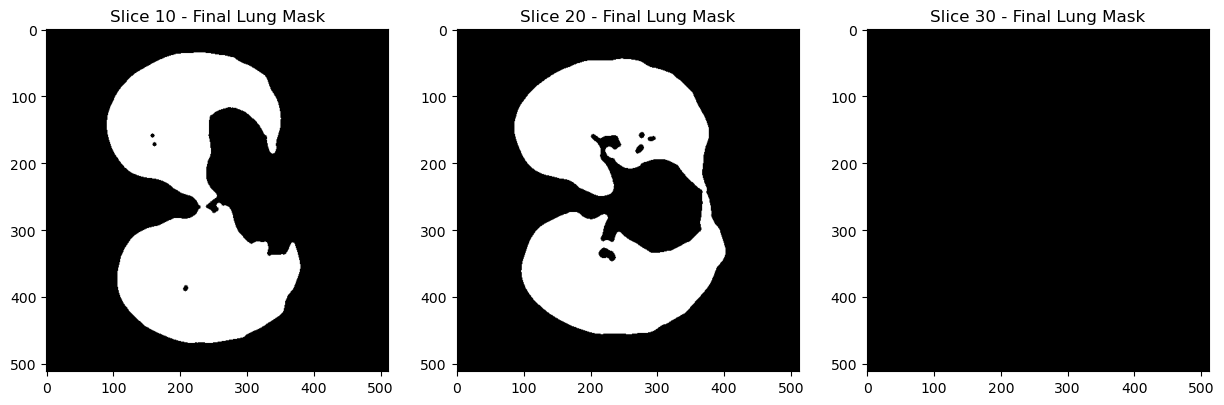

In [ ]:
from skimage.morphology import closing, opening, disk
from skimage.segmentation import clear_border

# 对每个切片进行形态学操作
final_lung_mask = np.zeros_like(inner_lung_mask)
for i in range(data.shape[2]):
    cleared = clear_border(inner_lung_mask[:, :, i])
    closed = closing(cleared, disk(3))
    opened = opening(closed, disk(3))
    final_lung_mask[:, :, i] = opened

# 可视化最终的肺部分割结果
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(final_lung_mask[:, :, 10], cmap='gray')
ax[0].set_title('Slice 10 - Final Lung Mask')
ax[1].imshow(final_lung_mask[:, :, 20], cmap='gray')
ax[1].set_title('Slice 20 - Final Lung Mask')
ax[2].imshow(final_lung_mask[:, :, 30], cmap='gray')
ax[2].set_title('Slice 30 - Final Lung Mask')
plt.show()


### 去除非肺部区域（基于区域属性）

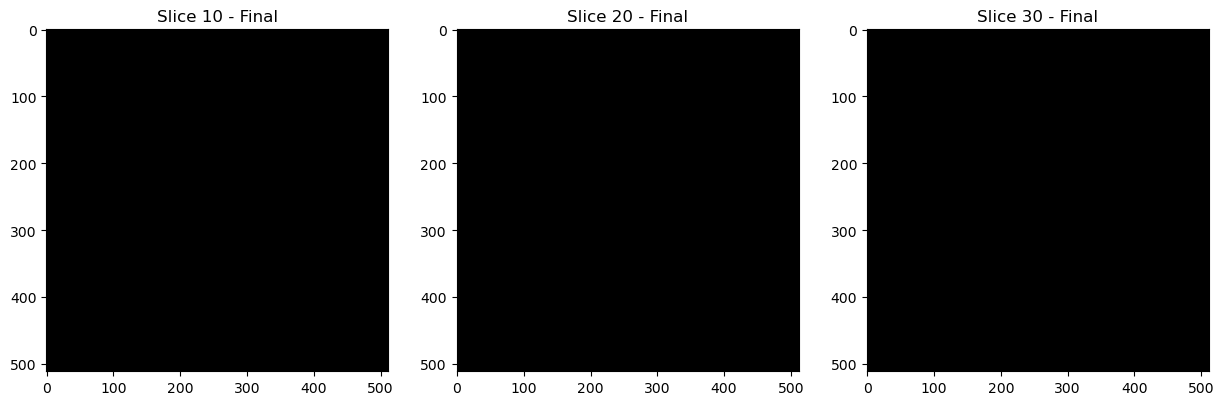

In [ ]:
from skimage.measure import label, regionprops

# 根据区域属性去除非肺部区域
final_data = np.zeros_like(processed_data)
for i in range(data.shape[2]):
    label_image = label(processed_data[:, :, i])
    regions = regionprops(label_image)
    
    for region in regions:
        if region.area >= 1000:  # 根据区域面积筛选
            final_data[:, :, i][label_image == region.label] = 1

# 可视化最终结果
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(final_data[:, :, 10], cmap='gray')
ax[0].set_title('Slice 10 - Final')
ax[1].imshow(final_data[:, :, 20], cmap='gray')
ax[1].set_title('Slice 20 - Final')
ax[2].imshow(final_data[:, :, 30], cmap='gray')
ax[2].set_title('Slice 30 - Final')
plt.show()
